Group Name: AG 39.

Student Name (Student ID):

1. Wong Ji Fong

2. Rohith Reddy Sankuru

3. Sweta Mishra

<b><span style="color:red">Type hinting is used within this document to help understand parameters  
Please run the following cell as type hints refer to self:</span></b>

In [1]:
from __future__ import annotations
# Assistive imports
from collections import namedtuple
from typing import Tuple, List, Optional, Set, Union, Generator
from heapq import heappush, heappop
from collections import deque
from functools import partial


import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.animation as animation

<b><span style="color:red">In addition, due to `Iterative deepening search` and `Depth-First Search` using cycle-check, the notebook may freeze due to taking almost O(nlog n) or more time for each iteration traversing back up the tree to do the cycle check. In such case, please restart the kernel using `Kernel -> Restart & Run all` in the Jupyter notebook toolbar</span></b>

# Table of contents

* [Question 1 definition](#Question-1)
* [Q1.a: Class Maze(Problem) [3 Marks]](#Q1.a:-Class-Maze(Problem)-[3-Marks])
* [Q1.b: Analysis of the Algorithms [7 Marks]](#Q1.b:-Analysis-of-the-Algorithms-[7-Marks])
* [Definitions](#Definitions)
    * [Problem definition](#Problem-definition)
    * [namedtuple `NewState` definition](#namedtuple-NewState-definition)
    * [Node definition](#Node-definition)
    * [Maze definition](#Maze-definition)
* [Maze (problem) setup](#Maze-(problem)-setup)
* [Analysis of the Algorithms](#Analysis-of-the-Algorithms)
    * [Breadth First Search](#Breadth-First-Search)
    * [Depth-First Search with Cycle-check](#Depth-First-Search-with-Cycle-check)
    * [Iterative deepening with cycle check](#Iterative-deepening-with-cycle-check)
    * [Informed Search (generalised)](#Informed-Search-(generalised))
    * [Uniform Cost Search](#Uniform-Cost-Search)
    * [A* Search](#A*-Search)
    * [Greedy Best-first Search](#Greedy-Best-First-Search)
* [Visualising the algorithms](#Visualising-the-algorithms)
* [Summary of data](#Summary-of-data)
* [Visualising algorithm performances](#Visualising-algorithm-performances)
* [Conclusion](#Conclusion)
* [Visualising algorithm path expansions and goal finding (video)](#Visualising-algorithm-path-expansions-and-goal-finding-(video))

# Question 1

Consider the maze shown below. The Maze has 16 rows and 24 columns The objective is to find a shortest path from cell $S$ to cell $G$.


![Maze](Maze_Assignment_1-1.jpg)


The agent can take four actions in each cell: 'RIGHT', 'DOWN', 'UP', 'LEFT'.  

Each cell is represented as $(x,y)$, where $x$ indicates row number and $y$ indicates column number. Action 'UP' takes the agent from cell $(x,y)$ to $(x+1,y)$. Action 'DOWN' takes the agent from cell $(x,y)$ to $(x-1,y)$. Action 'RIGHT' takes the agent from cell $(x,y)$ to $(x,y+1)$. Action 'LEFT' takes the agent from cell $(x,y)$ to $(x,y-1)$. The triplet $(s,a,s')$  indicates that taking action $a$ at state $s$ leads to state $s'$. Actions 'LEFT' or 'RIGHT' cost 10 units for all $(s,a,s')$. Actions 'UP' or 'DOWN' cost 1 unit for all  $(s,a,s')$.  The agent cannot move into cells that are shaded. Assume that the agent knows the boundaries of the maze and has full observability. Consequently, at the bottom (row 0) and top (row 15), the agent will not take actions 'DOWN' and 'UP', respectively; at left (column 0) and right (column 23) columns, the agent will not take 'LEFT' and 'RIGHT' actions, respectively. Similalry, the agent will not take actions that lead to shaded region in the maze.

## **Q1.a: Class Maze(Problem)** [3 Marks]

Write a Maze class to create a model for this problem. You should not use an explicit state space model. The modelling should inherit the abstract class 'Problem' (given below). With the problem formulation, find the shortest path from S to G cell. Propose and implement multiple heuristics (at least two heuristics) for informed search algorithms. 

## **Q1.b: Analysis of the Algorithms** [7 Marks]

1. Solve the above Maze problem using the following algorithms

    a. Breadth-First Search 

    b. Depth-First Search with Cycle-Check

    c. Iterative-Deepening Search with Cycle-Check

    d. Uniform-Cost Search

    e. A* Search 

    f. Greedy Best-first Search

    g. Any other variants for search algorithms that are not discussed in the class (bonus/optional question) 

2. Identify the number of nodes generated, number of nodes expanded, maximum frontier size, and path-cost for the above algorithms. 
 
3. Compare the performance of informed search algorithms with proposed heuristics. Identify the best performing heuristic and explain.
 
4. Draw a bar plot comparing the statistics of the algorithms and explain the results. 

Note 1: You must follow the problem formulation discussed in the class. A abstract class for Problem amd Node definition is presented below. The search tree generation should follow the template discussed in the class (i.e., Node class, expand methods, etc.). 

Note 2: If you are borrowing a block of code (for example, helper functions or data structures, etc.) from AIMA4e repository, you have to acknowledge it in the code. 

Note 3: The code should be written in a single jupyter notebook file.

## Definitions

## Problem definition

In [2]:
class Problem:
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states 
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds)
        
    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0
    
    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)

## namedtuple `NewState` definition

The following were added to the document:  

Named tuple NewState to define a tuple like object with names. This helps to debug and understand the difference between a possible states (herein called NewState) that nodes can take, and Nodes that are expanded.  
```python
NewState = namedtuple('NewState', ['cost', 'coordinates', 'action'])
```

In particular, the named tuple is for readability, while retaining immutability and ephemeral use.

In [3]:
NewState = namedtuple('NewState', ['cost', 'coordinates', 'action'])

## Node definition

In [4]:
# Use the following Node class to generate search tree
import math

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(
            state=state,
            parent=parent,
            action=action,
            path_cost=path_cost
        )
    
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost 
    
    # newly defined to assist with trace, and repr redefined
    # for readability
    def __repr__(self):
        """
        Newly defined to assist with trace, and track
        available states throughout the document
        """
        return '<state:(x:{},y:{}) path_cost:{} action:{}>'\
                .format(self.state[0], self.state[1], self.path_cost, self.action)
    
    def __eq__(self, other: Node) -> bool:
        """
        Tests for equality between two instances of a Node.
        Nodes with different states or different path costs 
        are now defined to be treated seperately.
        Args:
            other (Node): 
                Node to compare with (implicitly executed)
                by python when doing comparisons such as node1 == node2
        """
        return self.state == other.state
    
    def expand_node(self, state: NewState) -> Node:
        """
        Expands on a single state. Method takes a new state and expands 
        by instantiating a new node instance and assigning the 
        costs as the costs so far, and saving the action taken from
        parent_node -> child_node as child.action.
        
        Args:
            state (NewState): 
                Expects a namedtuple as defined in the cell above.
            
        Returns:
            Node: Expanded child node
        """
        expanded_node = Node(state.coordinates)
        expanded_node.parent = self
        expanded_node.path_cost = self.path_cost + state.cost
        expanded_node.action = state.action
        return expanded_node
    
    def expand(
            self,     
            permissable_actions: List[NewState]
        ) -> List[Node]:
        """
        Args:
            permissable_actions (List[NewState]):
                List of possible actions to take
        
        Returns:
            Generator[Node]:
                Generator of child nodes for this node.
        """
        return map(self.expand_node, permissable_actions)
    
    def __bool__(self):
        """
        Assist with assigning truthyness to the Node class
        e.g. is node == True if state is truthy
        """
        return True if self.state else False
    
    def __hash__(self):
        """
        Allows this class to be used in objects that require
        hashes such as sets, keys in dicts.
        """
        return hash(self.state)

## Maze definition

In [5]:
class Maze(Problem):
    def __init__(self,
                 initial: Node,
                 goal: Node,
                 boundaries: Tuple[int, int],
                 action_cost_map: Optional[dict],
                 **kwds):
        """
        Add type hints and parameter to know boundaries
        given the assumption "Assume that the agent knows
        the boundaries of the maze and has full observability"
        
        Args:
            initial (Node): Node for the initial state
            goal (Node): Node for the goal state
            boundaries (Tuple[int,int]):
                (rows, cols) of boundaries, assuming (0,0) to (rows,cols) 
                as problem space
        """
        super().__init__(initial=initial,
                         goal=goal,
                         boundaries=boundaries,
                         action_cost_map=action_cost_map,
                         **kwds)
    
    def action_cost(self, node: Node, action: str) -> int:
        """
        Args:
            node (Node): Current node state
            action (str): Action to take
        
        Returns:
            int: Cost (s, a, s')
        """
        return self.action_cost_map[action]
    
    def _transform_permissable_action(self,
                                      actions: Tuple[Tuple[int, int], str],
                                      node: Node) -> Node:
        state, action = actions
        action_cost = self.action_cost(node, action)
        return NewState(action_cost, state, action)
        
    def actions(self, node: Node) -> List[NewState]:
        """
        Return permissable actions as list of actions
        as (COST, s', ACTION)
        Args:
            node (Node): Agents current state node
        
        Returns:
            List[NewState]:
                List of permissable states and actions to expand to
                for the given node.
        """
        x = node.state[0]
        y = node.state[1]
        parent = node.parent.state if node.parent else None
        
        actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
        
        permissable_x_y = {((x+1, y), 'UP'),
                           ((x-1, y), 'DOWN'),
                           ((x, y+1), 'RIGHT'),
                           ((x, y-1), 'LEFT')}
        
        return list(
                    map(
                        lambda actions: self._transform_permissable_action(actions, node),
                        filter(
                                lambda result:
                                   # Ensuring they permissable actions are:
                                   # * within boundaries
                                   # * not a shaded region
                                   0<=result[0][0]<self.boundaries[0] and
                                   0<=result[0][1]<self.boundaries[1] and
                                   (result[0][0], result[0][1]) not in self.shaded_regions,
                               permissable_x_y
                        )
                )
           )
    
    def result(self, state: Node, action: str) -> Node:
        """
        Gives the state as a result of taking the action
        specified
        Args:
            state (Node): Node state
            action (str): Action to take from node s
        
        Returns:
            Tuple[int, int]:
                New state / coordinate
        """
        permissable_x_y = {
            'UP': (1, 0),
            'DOWN': (-1, 0),
            'RIGHT': (0, 1),
            'LEFT': (0, -1)
        }
        change = permissable_x_y[action]
        return ((state.state[0] + change[0],
                state.state[1] + change[1]), action)
    
    def h(self, node: Node) -> Union[float, int]:
        """
        Implementing Manhatten distance.
        One of two of the heuristics for Q1.a
        
        Args:
            node (Node): Current agent node
        
        Returns:
            Union[float, int]: heuristic value
        """
        return abs(self.goal.state[0]-node.state[0]) + \
                abs(self.goal.state[1]-node.state[1])
    
    def h2(self, node: Node) -> Union[float, int]:
        """
        Implementing Euclidean distance
        One of two of the heuristics for Q1.a
        Args:
            node (Node): Current agent node
        
        Returns:
            Union[float, int]: heuristic value
        """
        return ((self.goal.state[0]-node.state[0])**2 + 
                (self.goal.state[1]-node.state[1])**2)**(1/2)
        
        
    def __repr__(self):
        """
        Assigning a readable representation of the object.
        """
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)
    
    def is_cycle(self, node: Node) -> bool:
        """
        Args:
            node (Node): Checks if a node is cyclic along its parent nodes
        
        Returns:
            bool: True if it is cyclic, else False.
        """
        visited = set()
        state = node.state
        while node.parent:
            if node.parent.state == state:
                return True
            node = node.parent
        return False
    
    def is_goal(self, node) -> bool:
        """
        Args:
            node (Node):
                Helper function to check if a certain node is the goal
                node based on the parameters of this maze.
        
        Returns: 
            bool:
                True if it is the goal node, false if not
        """
        return node.state == self.goal.state

## Maze (problem) setup

Instantiating start and goal nodes:

In [6]:
start_node = Node((8,10))
goal_node = Node((11,9))

Instantiating maze with start, end, maze size, boundaries, action costs and shaded regions (not known to agent itself):

In [7]:
maze = Maze(start_node,
            goal_node,
            boundaries=(16, 24),
            action_cost_map={'LEFT': 10, 'RIGHT': 10, 'UP': 1, 'DOWN': 1},
            shaded_regions = {(7, 9),(6, 9),(10, 12),
                              (10, 13),(11, 12),(10, 9),
                              (12, 10),(9, 9),(13, 10),
                              (8, 9),(11, 13),(10, 10),
                              (14, 9),(11, 10)})

## Analysis of the Algorithms

1. [Breadth-First Search](#Breadth-First-Search)
2. [Depth-First Search with Cycle-check](#Depth-First-Search-with-Cycle-check)
3. [Iterative deepening with cycle check](#Iterative-deepening-with-cycle-check)
4. [Informed Search (generalised)](#Informed-Search-(generalised))
4. [Uniform Cost Search](#Uniform-Cost-Search)
5. [A* Search](#A*-Search)
6. [Greedy Best-first Search](#Greedy-Best-First-Search)

Note: Parts of the following algorithms have additional variables to keep track of data  

* `actions` (list): To track expanded and created nodes
* `current_frontier_size` (int): To track frontier size at a given time
* `maximum_frontier_size` (int): To track maximum frontier size for the function

### Helper functions (Please run this cell)

In [8]:
def print_stats(node: Node,
                algo_actions: List[Tuple[Tuple[int, int], str]],
                max_frontier_size: int,
                explored_count: int) -> None:
    if isinstance(node, Node):
        print((f'Max frontier: {max_frontier_size}'
               f'\nNodes Generated: {explored_count}'
               f'\nExpanded: {len(list(filter(lambda x: x[1] == "expanded", algo_actions)))}'
               f'\nPath Cost: {node.path_cost}'))
    else:
        print((f'Max frontier: {max_frontier_size}'
               f'\nNodes Generated: {explored_count}'
               f'\nExpanded: {len(list(filter(lambda x: x[1] == "expanded", algo_actions)))}'
               f'\nPath Cost: nil, not found'))

algorithm_results = {}
def save_results(algorithm:str,
                node: Node,
                algo_actions: List[Tuple[Tuple[int, int], str]],
                max_frontier_size: int,
                explored_count: int) -> None:
    """
    Args:
        algorithm (str): Algorithm name
        node (Node): solution node
        algo_actions (List[Tuple[Tuple[int, int], str]]):
            List of coordinate,actions taken by the algo
        max_frontier_size (int): Maximum frontier size for the algo
        explored_count (int): Nodes explored for the algo
    
    Updates:
        algorithm_results
    """
    algorithm_results[algorithm] = {
        'solution_node': node,
        'expanded': len(list(filter(lambda x: x[1] == "expanded", algo_actions))),
        'algo_actions': algo_actions,
        'max_frontier_size': max_frontier_size,
        'explored_count': explored_count
    }

### Breadth First Search

In [9]:
def breadth_first_search(
        maze: Maze
    ) -> (Node, List[Tuple[int, int]], int):
    """
    Args:
        maze (Maze): Maze class to run the search on
    
    Returns:
        solution (Node):
            Node for which the solution was found
        algo_actions (List[Tuple[Tuple[int, int], str]]):
            List of coordinate,actions taken by the algo
        maximum_frontier_size (int):
            Maximum frontier size of this algo
        nodes_generated (int):
            Number of nodes generated by the algorithm
    """
    initial_node = maze.initial
    if maze.is_goal(initial_node):
        algo_actions.append((initial_node.state, 'expanded'))
        return initial_node, algo_actions, 1, 1
    
    frontier = deque([initial_node])
    visited = set([initial_node])
    
    algo_actions = []
    current_frontier_size = 1
    maximum_frontier_size = 1
    nodes_generated = 1
    
    while frontier:
        frontier_node = frontier.popleft()
        current_frontier_size -= 1
        
        actions = maze.actions(frontier_node)
        for child in frontier_node.expand(actions):
            if maze.is_goal(child):
                return (child,
                        algo_actions,
                        maximum_frontier_size,
                        nodes_generated)
            if child not in visited:
                visited.add(child)
                frontier.append(child)
                algo_actions.append((child.state, 'generated'))
                nodes_generated += 1
                
                current_frontier_size += 1
                if current_frontier_size > maximum_frontier_size:
                    maximum_frontier_size = current_frontier_size
        algo_actions.append((frontier_node.state, 'expanded'))
    raise Exception('Unable to find target')

In [10]:
bfs_results = breadth_first_search(maze)

In [11]:
save_results('Breadth first search', *bfs_results)
print_stats(*bfs_results)

Max frontier: 31
Nodes Generated: 207
Expanded: 175
Path Cost: 39


### Depth-First Search with Cycle-check

In [12]:
def depth_first_search_with_cycle_check(
        maze: Maze,
        curnode: Node,
        current_frontier_size : int,
        algo_actions: List[Tuple[int, int]] = [],
        maximum_frontier_size: int = 0,
        nodes_generated: int = 0
    ) -> bool:
    """
    Args:
        maze (Maze): Maze class to run the search on
        curnode (Node): Node for which we are searching on
        current_frontier_size (int): frontier size for this interation
        algo_actions (List[Tuple[Tuple[int, int], str]]):
            List of coordinate,actions taken by the algo
        maximum_frontier_size (int): Maximum frontier size at any time
        nodes_generated (int): Number of nodes generated so far
    
    Returns:
        solution (Node):
            Node for which the solution was found
        expanded_nodes (List[Tuple[int, int]]):
            Nodes for which was visited
        maximum_frontier_size (int):
            Maximum frontier size of this algo
        nodes_generated (int):
            Explored nodes
    """
    if maze.is_goal(curnode):
        return curnode, algo_actions, maximum_frontier_size, nodes_generated
    
    if current_frontier_size > maximum_frontier_size:
        maximum_frontier_size = current_frontier_size
    
    actions = maze.actions(curnode)
    if not maze.is_cycle(curnode):
        for child in curnode.expand(actions):
            nodes_generated += 1
            algo_actions.append((child.state, 'generated'))
            (solution_node,
             algo_actions,
             frontier_size,
             nodes_generated) = depth_first_search_with_cycle_check(
                                    maze,
                                    child,
                                    1 + current_frontier_size,
                                    algo_actions,
                                    maximum_frontier_size,
                                    nodes_generated
                                )
            if frontier_size > maximum_frontier_size:
                maximum_frontier_size = frontier_size
            
            if isinstance(solution_node, Node):
                return (solution_node,
                         algo_actions,
                         maximum_frontier_size,
                         nodes_generated)
    algo_actions.append((curnode.state, 'expanded'))
    return None, algo_actions, maximum_frontier_size, nodes_generated

In [13]:
dfs_results = depth_first_search_with_cycle_check(maze, maze.initial, 0)

In [14]:
save_results('Depth first search with cycle check', *dfs_results)
print_stats(*dfs_results)

Max frontier: 115
Nodes Generated: 67529
Expanded: 67443
Path Cost: 509


### Iterative deepening with cycle check

In [15]:
# Uncomment below if a recursion limit is reached as
# it may require a level of recursion to check 
# the path cost so far

import sys

sys.setrecursionlimit(500000) 

def depth_limited_search(
        maze: Maze,
        limit: int,
        algo_actions: List[Tuple[Tuple[int, int], str]],
        nodes_generated: int=1
    ) -> (Union[Node, str],
          List[Tuple[int, int]],
          int,
          int):
    """
    Args:
        maze (Maze): Maze to solve
        l (int): limit for which to apply as cutoff
        expanded (list): To track expanded nodes
        nodes_generated (int): number of nodes generated. Includes initial
    
    Returns:
        Union[Node, str]:
            str returned on failure to find solution;
            else node returned if found
        algo_actions (List[Tuple[Tuple[int, int], str]]):
            List of coordinate,actions taken by the algo
        max_frontier_size int:
            Maximum frontier size of this iteration
            of depth limited search
        size_of_frontier int:
            Remaining length of frontier on exiting this function
    """
    frontier = [maze.initial]
    if maze.is_goal(maze.initial):
        algo_actions.append((maze.initial.state, 'expand'))
        return maze.initial, algo_actions, 1, 1
    
    solution = 'FAIL'
    
    current_frontier_size = 1
    max_frontier_size = 1
    
    while frontier:
        frontier_node = frontier.pop()
        current_frontier_size -= 1
        
        if maze.is_goal(frontier_node):
            return frontier_node, algo_actions, max_frontier_size, nodes_generated
        
        if len(frontier_node) > limit:
            solution = 'CUTOFF'
            return solution, algo_actions, max_frontier_size, nodes_generated
        else:
            actions = maze.actions(frontier_node)
            
            if not maze.is_cycle(frontier_node):
                for child in frontier_node.expand(actions):
                    algo_actions.append((frontier_node.state, 'generated'))
                    nodes_generated += 1

                    frontier.append(child)
                    current_frontier_size += 1
                    if current_frontier_size > max_frontier_size:
                        max_frontier_size = current_frontier_size
            algo_actions.append((frontier_node.state, 'expanded'))
    return solution, algo_actions, max_frontier_size, nodes_generated

def iterative_deepening_search(
        maze: Maze,
        nodes_generated:int=0
    ) -> (Union[Node, str], List[Tuple[int, int]], int):
    """
    Args:
        maze (Maze): Maze problem class to solve
        depth (int): Depth to limit the search to
    
    Returns:
        Union[Node, str]:
            Node or exit message
        Tuple[List[Tuple[int, int]], str]:
            List of coordinate,actions taken by the algo
        int:
            # of explored nodes
    """
    algo_actions = []
    max_frontier_size = 0
    all_frontier_size = 0
    nodes_generated = 0
    depth = 0
    
    # As we assumed that the agent knows the boundaries 
    # of the maze and has full observability, max d
    # will only be all the cells in the boundaries.
    # Agent is not assumed to know shaded areas hence not calculated in
    while depth < maze.boundaries[0] * maze.boundaries[1]:
        depth += 1
        
        (result,
         algo_actions, 
         frontier_size, 
         nodes_generated) = depth_limited_search(maze, depth, algo_actions, nodes_generated)
        
        if frontier_size > max_frontier_size:
            max_frontier_size = frontier_size
        
        if isinstance(result, Node) or result == 'FAIL':
            return result, algo_actions, max_frontier_size, nodes_generated
    return 'FAIL', algo_actions, max_frontier_size, nodes_generated

In [16]:
ids_results = iterative_deepening_search(maze)

In [17]:
save_results('Iterative deepening search', *ids_results)
print_stats(*ids_results)

Max frontier: 179
Nodes Generated: 11773
Expanded: 4385
Path Cost: 445


## Informed Search (generalised)

General informed search algorithm

In [18]:
def informed_search(
        maze: Maze,
        f: Callable
    ) -> (Node, Tuple[List[Tuple[int, int]], str], int):
    """Uses priority queues (in python, heapq module) to minimise 
    the target function.
    
    Args:
        maze (Maze): Maze to run search on
        f (Callable): Target function to minimise.
    
    Returns:
        child (Node): Solution node
        algo_actions (Tuple[List[Tuple[int, int]], str]):
            List of coordinate,actions taken by the algo
        max_frontier_size (int): Maximum frontier size
        explored (int): Sum of nodes explored
    """
    initial_node = maze.initial
    
    frontier = [(f(initial_node), initial_node)]
    visited = {maze.initial.state: maze.initial}
    
    algo_actions = []
    current_frontier_size = 1
    max_frontier_size = 1
    nodes_generated = 0
    
    while frontier:
        heuristic, frontier_node = heappop(frontier)
        current_frontier_size -= 1
        
        actions = maze.actions(frontier_node)
        if maze.is_goal(frontier_node):
            return (frontier_node, 
                    algo_actions, 
                    max_frontier_size, 
                    nodes_generated)
        
        for child in frontier_node.expand(actions):
            if (child.state not in visited or 
                child.path_cost < visited[child.state].path_cost):
                nodes_generated += 1
                algo_actions.append((child.state, 'generated'))
                
                visited[child.state] = child
                heappush(frontier, (f(child), child))
                current_frontier_size += 1
                if current_frontier_size > max_frontier_size:
                    max_frontier_size = current_frontier_size
        algo_actions.append((frontier_node.state, 'expanded'))
    raise Exception('Unable to find target')

## Uniform Cost Search

Uniform cost search (UCS) is an uninformed search that only takes into account total path cost and uses no heuristics. As such, we use `partial` to curry the informed search function and feed in the f function

$$
f(n) = g(n) + h(n) \text{ where h(n) = 0}. \\
 \\
=> f(n) = g(n) + 0
$$

In [19]:
uniform_cost_search = partial(informed_search, f=lambda node: node.path_cost + 0)

In [20]:
ucs_results = uniform_cost_search(maze)

In [21]:
save_results('Uniform Cost Search', *ucs_results)
print_stats(*ucs_results)

Max frontier: 34
Nodes Generated: 123
Expanded: 91
Path Cost: 39


## A* Search
A* search is an informed search that takes into account total path cost and heuristics. As such, we use partial to curry the informed search function and feed in the f function:

$$
f(n) = g(n) + h(n)
$$

In [22]:
# Manhatten distance heuristic
astar_search_h = partial(informed_search, f=lambda node: node.path_cost + maze.h(node))
# Euclidean distance heuristic
astar_search_h2 = partial(informed_search, f=lambda node: node.path_cost + maze.h2(node))

In [23]:
astar_search_h_results = astar_search_h(maze)

In [24]:
save_results('A* Search (Manhatten distance h)', *astar_search_h_results)
print_stats(*astar_search_h_results)

Max frontier: 34
Nodes Generated: 98
Expanded: 65
Path Cost: 39


In [25]:
astar_search_h2_results = astar_search_h2(maze)

In [26]:
save_results('A* Search (Euclidean distance h2)', *astar_search_h_results)
print_stats(*astar_search_h_results)

Max frontier: 34
Nodes Generated: 98
Expanded: 65
Path Cost: 39


## Greedy Best First Search

Greedy Best First Search (GBFS) is an informed search that uses only heuristics $h(n)$ and does not take into account $g(n)$. Hence:

$$
f(n) = g(n) + h(n) \text{ where g(n) = 0}\\
=> f(n) = h(n)
$$

In [27]:
# Manhatten distance heuristic
gbfs_search_h = partial(informed_search, f=lambda node: maze.h(node))
# Euclidean distance heuristic
gbfs_search_h2 = partial(informed_search, f=lambda node: maze.h2(node))

In [28]:
gbfs_search_h_results = gbfs_search_h(maze)

In [29]:
save_results('Greedy Best First Search (Manhatten distance h)', *gbfs_search_h_results)
print_stats(*gbfs_search_h_results)

Max frontier: 17
Nodes Generated: 38
Expanded: 22
Path Cost: 61


In [30]:
gbfs_search_h2_results = gbfs_search_h2(maze)

In [31]:
save_results('Greedy Best First Search (Euclidean distance h2)', *gbfs_search_h2_results)
print_stats(*gbfs_search_h2_results)

Max frontier: 17
Nodes Generated: 38
Expanded: 22
Path Cost: 61


## Summary of data

Summary of all statistics on the algorithms

In [32]:
from IPython.display import HTML, display

def display_table(data):
    html = "<table>"
    for idx, row in enumerate(data):
        html += "<tr>"
        for field in row:
            if not idx == 0:
                html += f"<td>{field}</td>"
            else:
                html += f"<td><h4>{field}</h4></td>"
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

def extract_data(
    name: str,
    entry: dict
) -> List[str, int, int, int, int]:
    return [name,
           entry['explored_count'],
           entry['expanded'],
           entry['max_frontier_size'],
           entry['solution_node'].path_cost]

# Headers of table
table = [['Algorithm',
         'Nodes generated',
         'Nodes expanded',
         'Maximum Frontier size',
         'Path Cost']]
table.extend(
    list(
        map(
            lambda x: extract_data(*x),
            algorithm_results.items()
        )
    )
)

display_table(table)

Algorithm,Nodes generated,Nodes expanded,Maximum Frontier size,Path Cost
Breadth first search,207,175,31,39
Depth first search with cycle check,67529,67443,115,509
Iterative deepening search,11773,4385,179,445
Uniform Cost Search,123,91,34,39
A* Search (Manhatten distance h),98,65,34,39
A* Search (Euclidean distance h2),98,65,34,39
Greedy Best First Search (Manhatten distance h),38,22,17,61
Greedy Best First Search (Euclidean distance h2),38,22,17,61


## Conclusion
Based on this table and the graphs above, we can draw the following conclusions.

First, `A* search` almost always performs better than all the other algorithms for minimising path cost. This is consistent with theory, as A* search is an informed search algorithm that takes into account both heuristics and path costs when selecting nodes. As a result, it minimises path cost as much as possible. It loses out to `Greedy best first search` in all other areas (nodes generated, nodes expanded and maximum frontier size), but when it's tradeoff is arguably that it ends up with the lowest path cost and the most optimal solution. As a result, we can say that this algorithm is most suitable for searches with varying path costs (per this problem statement).

Second, `iterative deepening search` and `Depth first search with cycle check` most often generates paths with the highest path cost (Rerun this notebook with `Kernel -> Restart & Run all` a few times and observe the table above change). This is consistent as neither of these algorithms look at path costs and revisits nodes for doing `is_cycle` checks. In particular, iterative deepening searches usually generates more than average nodes for its algorithm runs. Though this is true, in theory, both Depth first search with cycle check and Iterative deepening search should consume less memory as neither implements a `visited` set. This is the trade off for the using cycle checks compared to instead of a datastructure to store visited nodes.

Heuristics-wise, both heuristics are equal in this case. This makes sense as given the start and end point, the heuristics values are almost always much lower than the actual path cost. When we change the problem statement, the heuristics value could factor in when making the choice to replace nodes. An example of this can be shown below:

In [33]:
modified_maze = Maze(start_node,
            goal_node,
            boundaries=(16, 24),
            action_cost_map={'LEFT': 10, 'RIGHT': 10, 'UP': 10, 'DOWN': 100},
            shaded_regions = {(7, 9),(6, 9),(10, 12),
                              (10, 13),(11, 12),(10, 9),
                              (12, 10),(9, 9),(13, 10),
                              (8, 9),(11, 13),(10, 10),
                              (14, 9),(11, 10)})

algorithm_results_modified_maze = {}
def save_results(algorithm:str,
                node: Node,
                algo_actions: List[Tuple[Tuple[int, int], str]],
                max_frontier_size: int,
                explored_count: int) -> None:
    """
    Args:
        algorithm (str): Algorithm name
        node (Node): solution node
        algo_actions (List[Tuple[Tuple[int, int], str]]):
            List of coordinate,actions taken by the algo
        max_frontier_size (int): Maximum frontier size for the algo
        explored_count (int): Nodes explored for the algo
    
    Updates:
        algorithm_results
    """
    algorithm_results_modified_maze[algorithm] = {
        'solution_node': node,
        'expanded': len(list(filter(lambda x: x[1] == "expanded", algo_actions))),
        'algo_actions': algo_actions,
        'max_frontier_size': max_frontier_size,
        'explored_count': explored_count
    }
save_results('Greedy best first search (manhatten distance)', *gbfs_search_h(modified_maze))
save_results('Greedy best first search (Euclidean distance)', *gbfs_search_h2(modified_maze))
save_results('A* search (manhatten distance)', *astar_search_h(modified_maze))
save_results('A* search (Euclidean distance)', *astar_search_h2(modified_maze))

# Headers of table
table_2= [['Algorithm',
         'Nodes generated',
         'Nodes expanded',
         'Maximum Frontier size',
         'Path Cost']]
table_2.extend(
    list(
        map(
            lambda x: extract_data(*x),
            algorithm_results_modified_maze.items()
        )
    )
)

display_table(table_2)

Algorithm,Nodes generated,Nodes expanded,Maximum Frontier size,Path Cost
Greedy best first search (manhatten distance),34,22,13,520
Greedy best first search (Euclidean distance),36,22,15,520
A* search (manhatten distance),234,195,40,390
A* search (Euclidean distance),237,197,41,390


Typically, Manhatten distance performs better for both heuristics based informed search algorithms in this problem statement example. This can be seen in the lower nodes generated for both algorithms for manhatten distance versus Euclidean distance for almost all facets to be evaluated. This is likely as the maze could be better represented using a Manhatten distance which uses a Manhatten 'block-like' approach to modelling the problem space.

## Visualising algorithm performances

In [34]:
table_t = [[] for i in range(len(table[0]))]
for idx, row in enumerate(table):
    for idy, col in enumerate(row):
        table_t[idy].append(col)

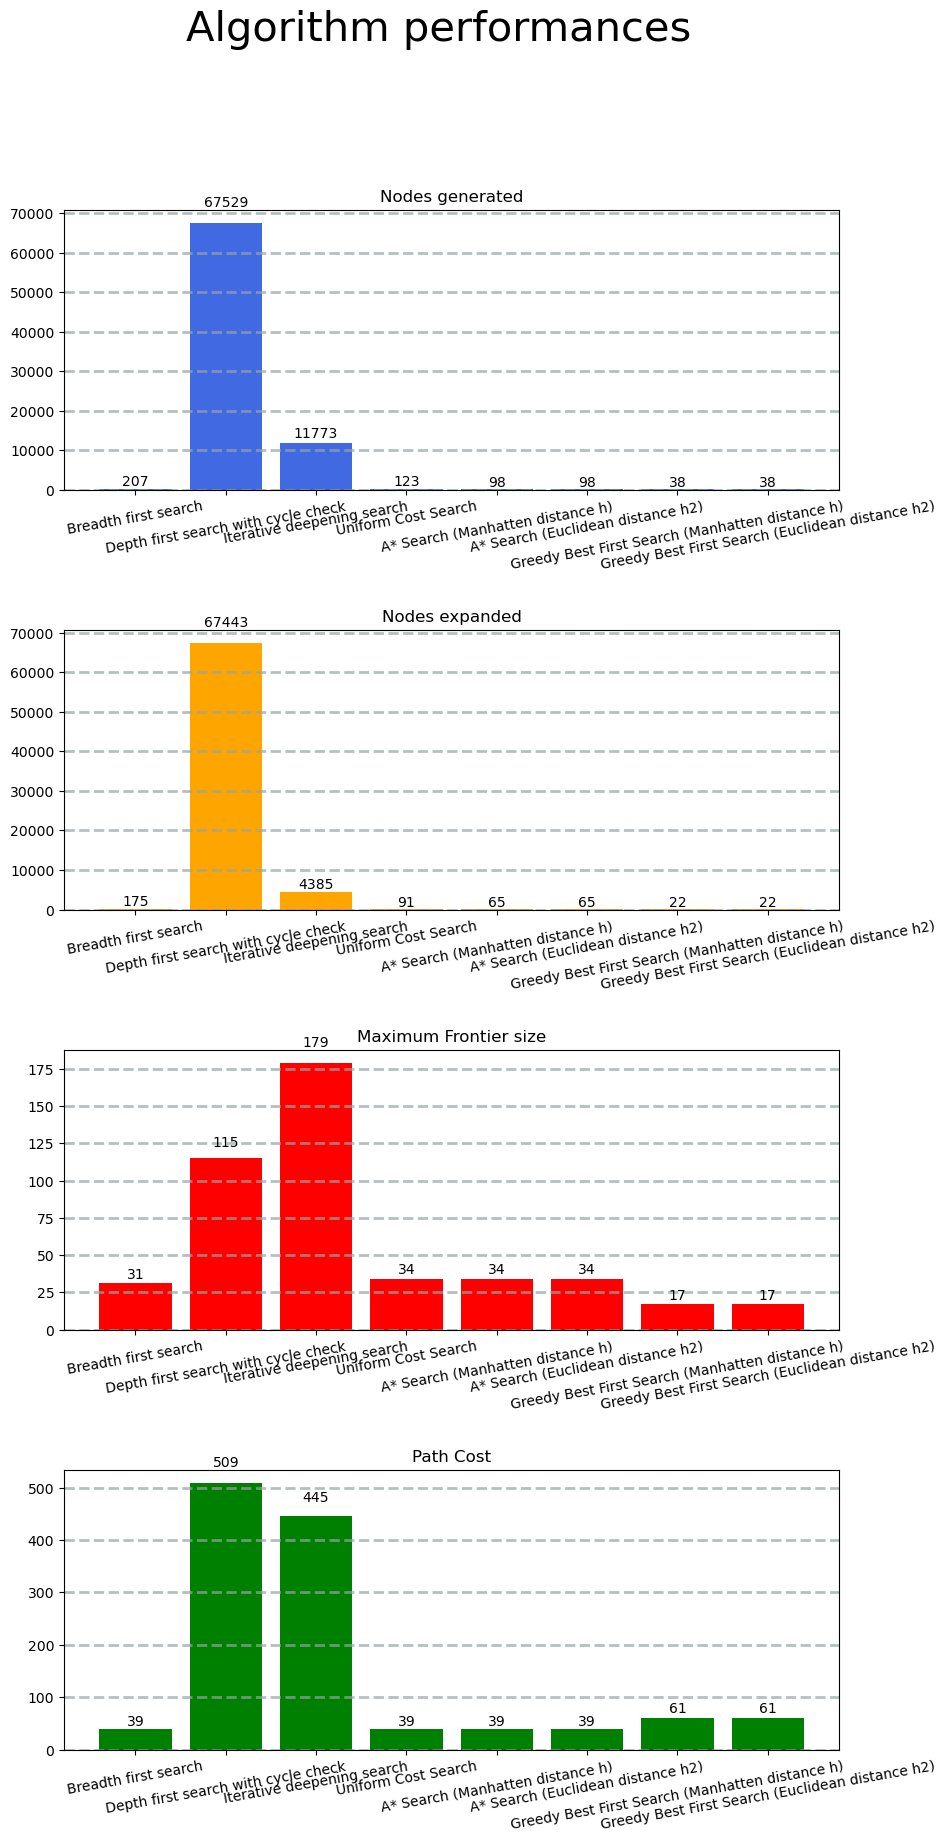

In [35]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,20))

fig.suptitle('Algorithm performances', fontsize=30)


def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

def plot_subplots(ax: plt.Axes, row:int, color:str):
    entries = len(table_t[0]) - 1
    ind = list(range(entries))
    algorithms = table_t[0][1:]
    
    ax.set_title(table_t[row][0])
    bar = ax.bar(range(entries), table_t[row][1:], color=color)
    ax.set_xticks(range(entries))
    ax.set_xticklabels(algorithms, rotation=10)
    ax.grid(color='#95a5a6', linestyle='--', linewidth='2', axis='y', alpha=0.7)
    autolabel(ax, bar)

plot_subplots(ax1, 1, 'royalblue')
plot_subplots(ax2, 2, 'orange')
plot_subplots(ax3, 3, 'red')
plot_subplots(ax4, 4, 'green')
plt.subplots_adjust(hspace=0.5) 

plt.savefig('performances.jpg')
plt.show()

## Visualising algorithm path expansions and goal finding (video)

Mazes are visual. To help visualise each algorithms effect in pathfinding, the following was implemented to assist with understanding each algorithms approach to finding the goal.

The following function is written in a way to run the function on-demand, then save the video on your local machine before displaying it in this notebook.

In [40]:
from IPython.display import Video

def init_maze(maze: Maze) -> List[List[int]]:
    """
    Initialises a row x col maze with 0s and plot
    maze parameters
    Args:
        maze (Maze): Maze / problem area
    
    Returns:
        List[List[int]]:
            row x col array of 0s
    """
    cols = maze.boundaries[1]
    rows = maze.boundaries[0]
    draw_maze = [[0 for j in range(cols)]
                     for i in range(rows)]
    
    draw_maze = plot_state(draw_maze, maze.initial.state, 'start')
    draw_maze = plot_state(draw_maze, maze.goal.state, 'end')
    
    for barrier in maze.shaded_regions:
        draw_maze = plot_state(draw_maze, barrier, 'barrier')
    
    return draw_maze

def plot_state(draw_maze, 
               coord:Tuple[int, int],
               marker_type:Literal['start',
                                   'end',
                                   'path',
                                   'expand',
                                   'barrier']):
    mapping = {
        'start': 10,
        'end': 20,
        'expanded': 30,
        'path': 40,
        'barrier': 50,
        'replace': 60,
        'generated': 70
    }
    draw_maze[-(coord[0]+1)][coord[1]] = mapping[marker_type]
    return draw_maze

def trace_all_states_taken(state: Node) -> List[str]:
    """
    Return path taken given node
    Args:
        state (Node): Node of a path
    
    Returns:
        List[str]:
            Actions taken in order from start
    """
    all_actions = []
    while state.action != None:
        all_actions.append((state.state, 'path'))
        state = state.parent
    return all_actions

def get_expanded_from_algo(
        maze: Maze,
        algo_func: Callable
    ) -> List[Node]:
    """
    Helper function to create the expand list
    Args:
        maze (Maze): Maze instance
        algo_func (Callable): Algo to run
    
    Returns:
        Tuple(Tuple[int, int], str) expansion type
    """
    algo_results = algo_func(maze)
    if isinstance(algo_results[0], Node):
        algo_results[1].extend(trace_all_states_taken(algo_results[0]))
    return algo_results[1]

def animate_algo(maze, 
                 expanded: List[Tuple[int,int], str], 
                 filename:str) -> str:
    """
    Args:
        expanded (List[Tuple[int,int], str):
            List of coordinate pairs and markers to display
        filename (str):
            Filename to save the video file of the algo as
    
    Returns:
        str: filename to play using IPython.display.Video
    """
    maze_map = init_maze(maze)

    def tick_range(n):
        value = -0.5
        arr = [value]
        while value < n-1:
            value += 1
            arr.append(value)
        return arr
    
    fig, ax = plt.subplots()
    cmap = colors.ListedColormap(
            ['white','green','red','blue', 'green', 'black', 'grey', 'lightblue']
    )
    bounds = [0,10,20,30,40,50,60,70,80]
    norm = colors.BoundaryNorm(bounds, cmap.N)
    data = ax.imshow(maze_map, cmap=cmap, norm=norm)
    ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
    rows=maze.boundaries[0]
    cols=maze.boundaries[1]
    col_ticks = tick_range(cols)
    row_ticks = tick_range(rows)
    ax.set_xticks(col_ticks)
    ax.set_yticks(row_ticks)
    ax.set_xticklabels(list(map(lambda x: int(x+0.5), col_ticks)))
    ax.set_yticklabels(list(map(lambda x: int(x+0.5), row_ticks[::-1])))
    
    def animate_func(i, maze_map):
        if expanded[i][0] == maze.initial.state:
            return [data]
        
        maze_map = plot_state(maze_map,
                              expanded[i][0],
                              expanded[i][1])
        data.set_data(maze_map)
        return [data]

    anim = animation.FuncAnimation(fig, 
                                   animate_func,
                                   frames=len(expanded),
                                   interval=30,
                                   fargs=(maze_map,),
                                   repeat=False)
    anim.save(filename, writer='ffmpeg') 
    return filename

def save_and_view_visualisation(
        algo: Literal['Breadth first search',
                      'Depth first search with cycle check',
                     'Greedy best first search h',
                     'Greedy best first search h2',
                     'Iterative deepening search',
                     'UCS',
                     'A* h',
                     'A* h2']
    ) -> Video:
    if algo not in ALGO_MAP:
        raise Exception('Please provide a corresponding algo name')
    expanded = get_expanded_from_algo(maze, ALGO_MAP[algo])
    try:
        return Video(animate_algo(maze, expanded, f'{algo}.mp4'))
    except RuntimeError:
        return Video(animate_algo(maze, expanded, f'{algo}.gif'))

In [ ]:
ALGO_MAP = {
    'Breadth first search': breadth_first_search,
    'Depth first search with cycle check': partial(depth_first_search_with_cycle_check,
                                                   curnode=maze.initial,
                                                   current_frontier_size=0),
    'Iterative deepening search': iterative_deepening_search,
    'Greedy best first search h': gbfs_search_h,
    'Greedy best first search h2': gbfs_search_h2,
    'UCS': uniform_cost_search,
    'A* h': astar_search_h,
    'A* h2': astar_search_h2
}

# Please input an algorithm name from the map above.
# save_and_view_visualisation('Breadth first search')
save_and_view_visualisation('Depth first search with cycle check')
# save_and_view_visualisation('Greedy best first search h')
# save_and_view_visualisation('Greedy best first search h2')
# save_and_view_visualisation('UCS')
# save_and_view_visualisation('A* h')
# save_and_view_visualisation('A* h2')